# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

# Installing dependencies

This notebook uses quantized models, and some additional libraries are required. If you are running this notebook on either Colab or Kaggle, please run the cell below once, then run the whole notebook normally.



In [ ]:
%%capture
%pip install -U transformers[torch] bitsandbytes trl peft sacremoses ctranslate2 accelerate

In [ ]:
import os
os.kill(os.getpid(), 9)

## Importing libraries

In [5]:
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding, 
    BitsAndBytesConfig,
    PreTrainedModel,
    DebertaV2Model, 
    DebertaV2Config, 
    pipeline
)
from transformers.trainer_utils import PredictionOutput
from transformers.models.deberta.modeling_deberta import ContextPooler

## Setting the device

In [6]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tqdm.pandas() # display tqdm on pandas apply functions
print(f"Using device: {device}")

Using device: cuda


## Setting Library Seeds

This step is necessary to guarantee reproducibility.



In [7]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Setting the Data Folder  

Please modify this path with your dataset's local path. The `data` folder should follow the official challenge structure:
```
data/
|---- arabic/
|--------- xxxx.tsv
|---- bulgarian/
|--------- xxxx.tsv
|---- english/
|--------- xxxx.tsv
|---- german/
|--------- xxxx.tsv
|---- italian/
|--------- xxxx.tsv
```

In [8]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

## Hugging face notebook login

To correctly download and use the hugging face models, a token key needs to be provided. Please refer to this [page](https://huggingface.co/docs/hub/security-tokens)

In [9]:
notebook_login()

# Subjectivity Class  
This class is used throughout the whole notebook as a utility toolbox to avoid code redundancy. When a method of this class is called for the first time, its behavior will be explained.  

In [10]:
class Subjectivity:
    """
    A class for handling multilingual subjectivity classification datasets.
    
    This class provides functionality to load, process, and prepare datasets for 
    subjective/objective text classification across multiple languages. It supports:
    - Loading and organizing datasets from multiple languages
    - Splitting data into train/dev/test sets
    - Analyzing label distributions
    - Loading pre-trained tokenizers and models
    - Computing class weights for imbalanced datasets
    
    Attributes:
        seed (int): Random seed for reproducibility
        device (str): Computation device ('cuda' or 'cpu')
        languages (list): List of available languages in the dataset
        dataset (pd.DataFrame): Combined dataset with all languages and splits
        train (pd.DataFrame): Training split of the dataset
        dev (pd.DataFrame): Development split of the dataset
        test (pd.DataFrame): Test split of the dataset
        all_data (dict): Nested dictionary organizing data by language and split
        tokenizer (AutoTokenizer, optional): Hugging Face tokenizer
        model (AutoModelForSequenceClassification, optional): Classification model
    """
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        """
        Initialize the Subjectivity class.
        
        Args:
            data_folder (str): Directory path containing the dataset files.
            seed (int): Random seed for reproducibility.
            device (str): Device to use for computations ('cuda' or 'cpu').
        """
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        """
        Create a consolidated dataset from files in multiple languages.
        
        Args:
            data_folder (str): Directory path containing subdirectories for each language.
            
        Returns:
            pd.DataFrame: Combined dataset with columns for sentence_id, sentence, label, 
                          language, and split information.
        """
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        """
        Split the dataset into training, development, and test sets.
        
        Args:
            dataset (pd.DataFrame): The combined dataset to split.
            print_shapes (bool): Whether to print the shapes of the resulting splits.
            
        Returns:
            tuple: A tuple containing three pandas DataFrames (train, dev, test).
        """
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        Organize the dataset by language and split (train, dev, test).
        
        Returns:
            dict: A nested dictionary with languages as the outer keys and
                  split names ('train', 'dev', 'test') as inner keys.
                  For example:
                  {
                      'english': {
                          'train': pd.DataFrame,
                          'dev': pd.DataFrame,
                          'test': pd.DataFrame
                      },
                      ...
                  }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        """
        Print the normalized distribution of labels in the dataset.
        
        Args:
            dataset (pd.DataFrame): The dataset containing a 'label' column.
            
        Returns:
            None: Prints the percentage distribution of each label.
        """
        print(dataset['label'].value_counts(normalize=True))

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        """
        Load a tokenizer from the Hugging Face model hub.
        
        Args:
            model_card (str): Identifier for the pre-trained tokenizer to load.
            
        Returns:
            AutoTokenizer: The loaded tokenizer.
        """
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        """
        Load a pre-trained model from the Hugging Face model hub.
        
        Args:
            model_card (str): Identifier for the pre-trained model to load.
            *args: Variable length argument list to pass to the model constructor.
            **kwargs: Arbitrary keyword arguments to pass to the model constructor.
            
        Returns:
            AutoModelForSequenceClassification: The loaded model.
        """
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        """
        Compute class weights for imbalanced datasets.
        
        Args:
            dataset (pd.DataFrame): Dataset containing a 'label' column.
            
        Returns:
            numpy.ndarray: Array of class weights where the index corresponds to the class label.
        """
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        return class_weights

## Creating Our Detector Object  

The `__init__()` method of the `Subjectivity` class will load the dataset, set the device and the seeds, and automatically create the `test`, `dev`, and `train` splits from the datasets. It will also convert the `SUBJ` and `OBJ` labels to their corresponding numerical versions, so they are ready to be fed into a model.  


In [11]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [12]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [13]:
detector.all_data['german']['train']['sentence'].str.len().describe()

count    800.000000
mean     126.296250
std       67.334117
min       31.000000
25%       80.000000
50%      112.500000
75%      161.000000
max      625.000000
Name: sentence, dtype: float64

Here we create the `results` dictionary and the `predictions_dict` dictionary. They will be used to store all the model's output

In [14]:
results = {}
predictions_dict = {}

# Custom Trainer  

This class extends the `Trainer` provided by Hugging Face. Since we needed to tweak some details in the training process, we opted to override some `Trainer` functions with custom ones.  


In [15]:
class CustomTrainer(Trainer):
    """
    Custom Trainer class extending Hugging Face's Trainer with additional functionality:
    - Support for class weights to handle imbalanced datasets
    - Custom loss computation with weighted cross-entropy
    - Threshold optimization for binary classification
    - Custom prediction with threshold application
    """
    
    def __init__(self, *args, class_weights=None, weights_dtype=torch.float32, **kwargs):
        """
        Initialize the CustomTrainer.
        
        Args:
            class_weights (array-like, optional): Weights for each class to handle class imbalance.
            weights_dtype (torch.dtype): Data type for the class weights tensor.
            *args, **kwargs: Arguments passed to the parent Trainer class.
        """
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=weights_dtype).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Compute the training loss with optional class weighting.
        
        Args:
            model: The model to train
            inputs: The inputs and targets of the model
            return_outputs (bool): Whether to return the outputs along with the loss
            num_items_in_batch: Not used but kept for compatibility
            
        Returns:
            torch.Tensor or tuple: Loss value alone or with model outputs
        """
        # Extract labels
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits 
        logits = outputs.get('logits')

        # Compute loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_best_threshold(self, dataset, ignore_keys=None, metric_key_prefix="test"):
        """
        Find the optimal classification threshold that maximizes macro F1 score.
        
        Args:
            dataset: The dataset to use for threshold optimization
            ignore_keys (list, optional): Keys to ignore in the model outputs
            metric_key_prefix (str): Prefix for metric keys in the output
            
        Returns:
            float: The optimal threshold value
        """
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)

        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()

        # Calculate optimal threshold
        labels = output.label_ids
        thresholds = np.linspace(0.1, 0.9, 100) 

        best_threshold = 0.5  # Default threshold
        best_f1 = 0

        for threshold in thresholds:
            predictions = (probabilities[:, 1] >= threshold).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Return the best threshold found
        return best_threshold
        
    def predict(self, dataset, threshold: float = 0.5, ignore_keys=None, metric_key_prefix="test"):
        """
        Generate predictions with a custom threshold for binary classification.
        
        Args:
            dataset: The dataset to generate predictions for
            threshold (float): The classification threshold (default: 0.5)
            ignore_keys (list, optional): Keys to ignore in model outputs
            metric_key_prefix (str): Prefix for metric keys in the output
            
        Returns:
            PredictionOutput: Object containing predictions, labels, and metrics
        """
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)
        
        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()
        
        final_predictions = (probabilities[:, 1] >= threshold).astype(int)

        # Update predictions in the output object
        return PredictionOutput(
            predictions=final_predictions,
            label_ids=output.label_ids,
            metrics=output.metrics
        )

## Text Tokenizer

In [16]:
def tokenize_text(texts):
    """
    Tokenize text data using the current tokenizer.
    
    Args:
        texts (dict): Dictionary containing text data with a 'sentence' field
        
    Returns:
        dict: Dictionary with tokenized text features including input_ids, 
              attention_mask, and potentially token_type_ids
    """
    return tokenizer(texts['sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

## Evaluation Metrics

In [17]:
def evaluate_metrics(eval_pred):
    """
    Calculate evaluation metrics for subjectivity classification models.
    
    This function computes various performance metrics for classification results:
    - Accuracy: Overall correctness of predictions
    - Macro-averaged precision, recall, and F1: Averages across both classes with equal weight
    - Class-specific metrics: Precision, recall, and F1 specifically for the subjective class
    
    Args:
        eval_pred (tuple): Tuple containing (predictions, labels) where:
            - predictions: Raw model outputs/logits with shape (n_samples, n_classes)
            - labels: Ground truth labels with shape (n_samples,)
            
    Returns:
        dict: Dictionary containing the following metrics:
            - macro_F1: Macro-averaged F1 score across all classes
            - macro_P: Macro-averaged precision across all classes
            - macro_R: Macro-averaged recall across all classes
            - SUBJ_F1: F1 score for the subjective class (label 1)
            - SUBJ_P: Precision for the subjective class
            - SUBJ_R: Recall for the subjective class
            - accuracy: Overall accuracy
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

## Saving Predictions

In [18]:
def save_predictions(test_data, predictions, filename: str, save_dir: str = 'results'):
    """
    Save model predictions to a TSV file with sentence IDs and predicted labels.
    
    Args:
        test_data: Dataset containing the 'sentence_id' field to match with predictions
        predictions: Array of binary predictions (0 for OBJ, 1 for SUBJ)
        filename: Name of the output file (should end with .tsv)
        save_dir: Directory to save the predictions file (default: 'results')
        
    Returns:
        str: Full path to the saved predictions file
    """
    os.makedirs(save_dir, exist_ok=True)
    pred_df = pd.DataFrame()
    pred_df['sentence_id'] = test_data['sentence_id']
    pred_df['label'] = predictions
    pred_df['label'] = pred_df['label'].apply(lambda x: 'OBJ' if x == 0 else 'SUBJ')

    predictions_filepath = os.path.join(save_dir, filename)
    pred_df.to_csv(predictions_filepath, index=False, sep='\t')

    print(f"Saved predictions into file:", predictions_filepath)
    return predictions_filepath

# Custom Model

In [19]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

## Sentiment Pipeline for Data Augmentation

In [20]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [21]:
def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

# Multilingual Training without Sentiment Pipeline

## mDeBERTa-base (multilingual)

In [22]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

72

In [23]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [24]:
language = 'multilingual'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.train)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2401 [00:00<?, ? examples/s]

Map:   0%|          | 0/2332 [00:00<?, ? examples/s]

In [25]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [26]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [27]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_multilingual_predicted.tsv


Saved predictions into file: results/test_multilingual_predicted.tsv
{'macro_F1': 0.6941601722041967, 'macro_P': 0.6906958894763773, 'macro_R': 0.7008144557735656, 'SUBJ_F1': 0.6114050558495003, 'SUBJ_P': 0.5764966740576497, 'SUBJ_R': 0.6508135168961201, 'accuracy': 0.7165523156089194}


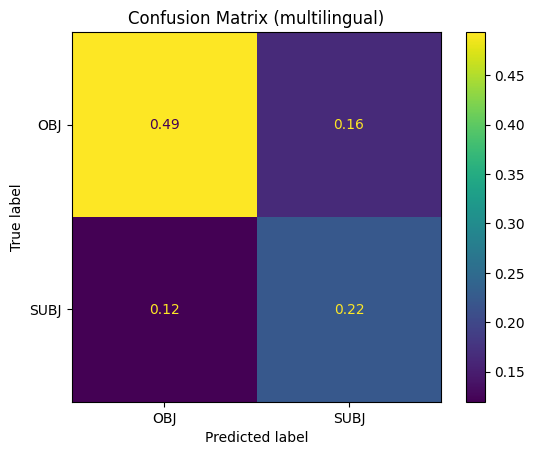

In [28]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mDeBERTa-base (multilingual without Arabic)

In [61]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5250

In [62]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [63]:
language = 'multilingual'
removed = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.train[detector.train['lang'] != removed])
dev_data = Dataset.from_pandas(detector.dev[detector.dev['lang'] != removed])
test_data = Dataset.from_pandas(detector.test[detector.test['lang'] != removed])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.train[detector.train['lang'] != removed])

Map:   0%|          | 0/3972 [00:00<?, ? examples/s]

Map:   0%|          | 0/1934 [00:00<?, ? examples/s]

Map:   0%|          | 0/1584 [00:00<?, ? examples/s]

In [64]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}-no-{removed}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [65]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}-no-{removed}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [66]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_multilingual_no_arabic_predicted.tsv


Saved predictions into file: results/test_multilingual_predicted.tsv
{'macro_F1': 0.7816960978966422, 'macro_P': 0.7906238776202238, 'macro_R': 0.7746298880563056, 'SUBJ_F1': 0.6886688668866886, 'SUBJ_P': 0.7228637413394919, 'SUBJ_R': 0.657563025210084, 'accuracy': 0.8213383838383839}


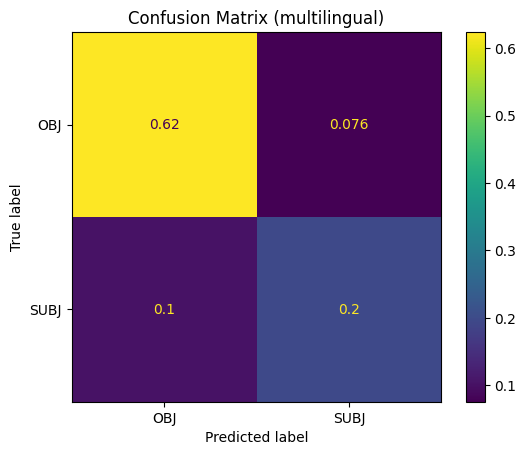

In [67]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_no_{removed}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_no_{removed}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-no-{removed}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# Multilingual Training with Sentiment Pipeline

## mDeBERTa-base (multilingual + sentiment)

In [29]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5279

In [30]:
language = 'multilingual'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [31]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [32]:
detector.train[['positive', 'neutral', 'negative']] = detector.train.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.dev[['positive', 'neutral', 'negative']] = detector.dev.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.test[['positive', 'neutral', 'negative']] = detector.test.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

100%|██████████| 2332/2332 [00:18<00:00, 128.92it/s]


In [33]:
train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.train)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2401 [00:00<?, ? examples/s]

Map:   0%|          | 0/2332 [00:00<?, ? examples/s]

In [34]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [35]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_multilingual_sentiment_predicted.tsv


Saved predictions into file: results/test_multilingual_sentiment_predicted.tsv
{'macro_F1': 0.6798492181682799, 'macro_P': 0.73863768566673, 'macro_R': 0.6691404046316866, 'SUBJ_F1': 0.5332278481012658, 'SUBJ_P': 0.7247311827956989, 'SUBJ_R': 0.42177722152690866, 'accuracy': 0.7469982847341338}


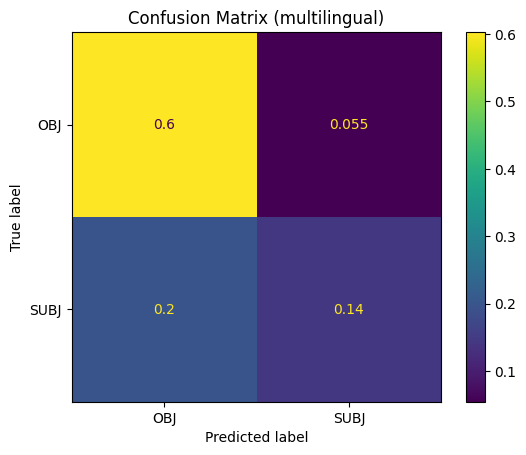

In [36]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mDeBERTa-base (multilingual + sentiment without Arabic)

In [83]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5266

In [84]:
language = 'multilingual'
removed = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [85]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}-no-{removed}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}-no-{removed}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [73]:
detector.train[detector.train['lang'] != removed][['positive', 'neutral', 'negative']] = detector.train[detector.train['lang'] != removed].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.dev[detector.dev['lang'] != removed][['positive', 'neutral', 'negative']] = detector.dev[detector.dev['lang'] != removed].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.test[detector.test['lang'] != removed][['positive', 'neutral', 'negative']] = detector.test[detector.test['lang'] != removed].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

100%|██████████| 3972/3972 [00:31<00:00, 126.68it/s]
<ipython-input-73-5812e33bd498>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detector.train[detector.train['lang'] != removed][['positive', 'neutral', 'negative']] = detector.train[detector.train['lang'] != removed].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
100%|██████████| 1934/1934 [00:15<00:00, 126.47it/s]
<ipython-input-73-5812e33bd498>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detector.dev[det

In [86]:
train_data = Dataset.from_pandas(detector.train[detector.train['lang'] != removed])
dev_data = Dataset.from_pandas(detector.dev[detector.dev['lang'] != removed])
test_data = Dataset.from_pandas(detector.test[detector.test['lang'] != removed])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.train[detector.train['lang'] != removed])

Map:   0%|          | 0/3972 [00:00<?, ? examples/s]

Map:   0%|          | 0/1934 [00:00<?, ? examples/s]

Map:   0%|          | 0/1584 [00:00<?, ? examples/s]

In [87]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}-no-{removed}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [88]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_multilingual_no_arabic_sentiment_predicted.tsv


Saved predictions into file: results/test_multilingual_no_arabic_sentiment_predicted.tsv
{'macro_F1': 0.796157173669434, 'macro_P': 0.8016120012166047, 'macro_R': 0.7914366107453812, 'SUBJ_F1': 0.7113513513513513, 'SUBJ_P': 0.732739420935412, 'SUBJ_R': 0.6911764705882353, 'accuracy': 0.8314393939393939}


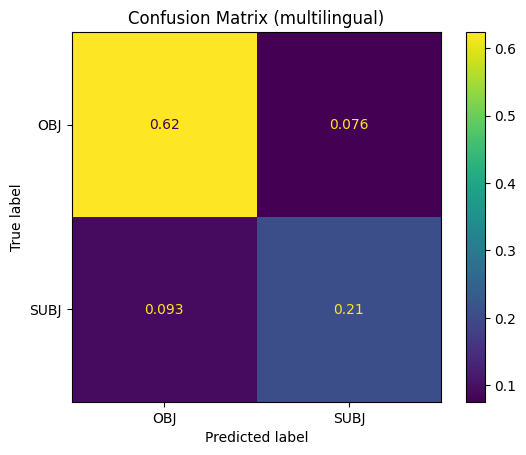

In [89]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_no_{removed}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_no_{removed}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-no-{removed}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

In [90]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False).round(4)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
multilingual-no-arabic-sentiment-thr,0.7962,0.8016,0.7914,0.7114,0.7327,0.6912,0.8314
multilingual-no-arabic-thr,0.7817,0.7906,0.7746,0.6887,0.7229,0.6576,0.8213
multilingual-thr,0.6942,0.6907,0.7008,0.6114,0.5765,0.6508,0.7166
multilingual-sentiment-thr,0.6798,0.7386,0.6691,0.5332,0.7247,0.4218,0.7470


In [ ]:
#model_card = "microsoft/mdeberta-v3-base"

#tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
#config = DebertaV2Config.from_pretrained(
#    model_card,
#    num_labels=2,
#    id2label={0: 'OBJ', 1: 'SUBJ'},
#    label2id={'OBJ': 0, 'SUBJ': 1},
#    output_attentions=False,
#    output_hidden_states=False
#)

# Initialize the custom model
#model = CustomModel(config=config, sentiment_dim=3, num_labels=2)

# Load pretrained weights from the original DeBERTa model
#model.deberta = DebertaV2Model.from_pretrained(model_card, config=config)

In [ ]:
#trainer.train()
#trainer.push_to_hub()